# EDA

In [28]:
!nvidia-smi

Tue Feb 28 07:43:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:0B:00.0 Off |                    0 |
| N/A   31C    P0    43W / 163W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup Environment

In [29]:
import matplotlib
%matplotlib inline

# sync python module
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Library

In [30]:
workspace_dir = '/nfs/Workspace/TeethSeg'
import sys
sys.path.append(workspace_dir)
import os

from monai.data import CacheDataset, DatasetSummary, DataLoader
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    Orientationd,
    ScaleIntensityRanged,
    ScaleIntensityRangePercentilesd,
    Spacingd,
    ToTensord,
    SqueezeDimd,
    LabelToMaskd
)
from monai.utils import first

import matplotlib.pyplot as plt
import pandas as pd

from data_utils.teeth_dataset import get_data_dicts
from data_utils.data_loader_utils import load_data_dict_json
from data_utils.visualization import show_img_lbl
from data_utils.utils import get_data_info

## Prepare data dicts

In [31]:
data_dir = '/nfs/Workspace/dataset/teeth/data_29'
data_json = os.path.join(data_dir, 'data.json')

In [32]:
# data_dicts = get_data_dicts(data_dir)
tr_ds, val_ds, tt_ds = load_data_dict_json(data_dir, data_json)

load json from /nfs/Workspace/dataset/teeth/data_29/data.json
train files (4): ['1001162439_20150708', '1001275319_20180114', '1001382496_20180423', '1001382496_20201206']
val files (2): ['1001470164_20180114', '1001487462_20180109']
test files (2): ['1001487462_20180527', '1001487462_20190427']


## Show data info

pid: 1001162439_20150708
file_pth: /nfs/Workspace/dataset/teeth/data_29/image/1001162439_20150708.nii.gz
img shape: [400, 400, 272]
img spacing: [0.4, 0.4, 0.39999962]
lbl shape: [400, 400, 272]
lbl spacing: [0.4, 0.4, 0.39999962]
lbl ids: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]


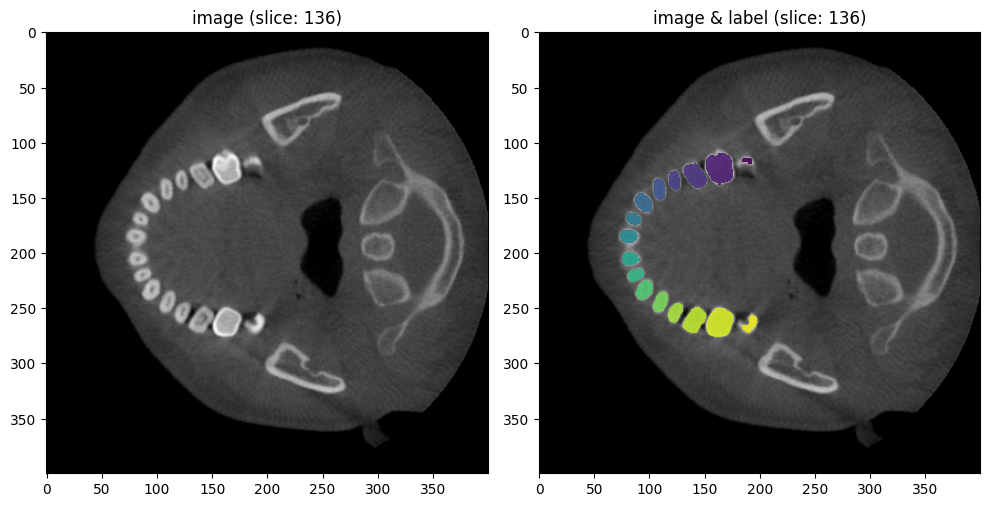

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: 1001275319_20180114
file_pth: /nfs/Workspace/dataset/teeth/data_29/image/1001275319_20180114.nii.gz
img shape: [400, 400, 280]
img spacing: [0.4, 0.4, 0.40000057]
lbl shape: [400, 400, 280]
lbl spacing: [0.4, 0.4, 0.40000057]
lbl ids: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]


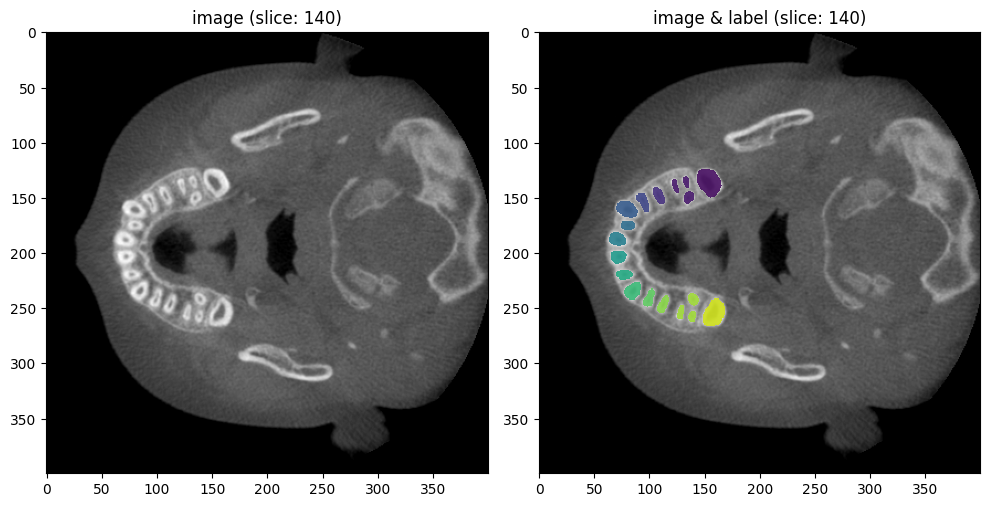

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: 1001382496_20180423
file_pth: /nfs/Workspace/dataset/teeth/data_29/image/1001382496_20180423.nii.gz
img shape: [400, 400, 280]
img spacing: [0.4, 0.4, 0.40000057]
lbl shape: [400, 400, 280]
lbl spacing: [0.4, 0.4, 0.40000057]
lbl ids: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]


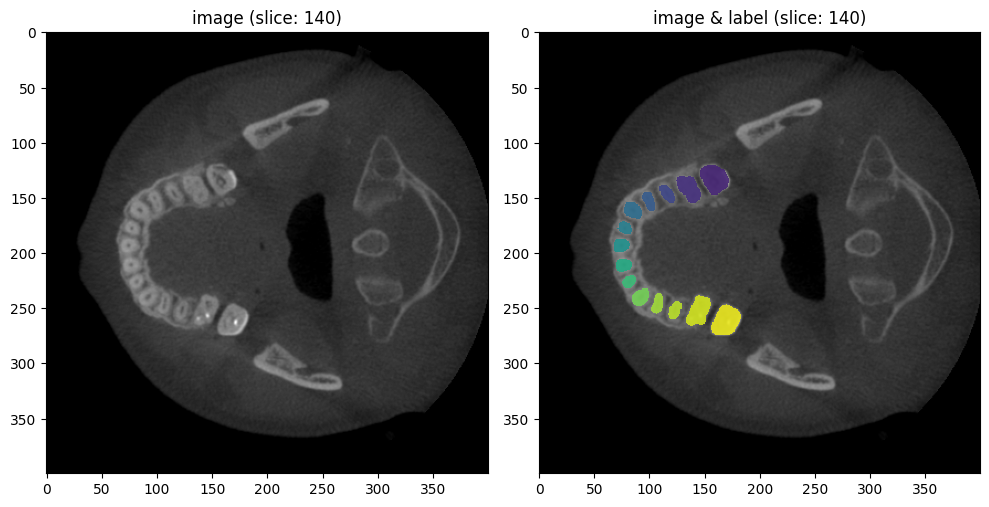

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: 1001382496_20201206
file_pth: /nfs/Workspace/dataset/teeth/data_29/image/1001382496_20201206.nii.gz
img shape: [400, 400, 328]
img spacing: [0.4, 0.4, 0.39999962]
lbl shape: [400, 400, 328]
lbl spacing: [0.4, 0.4, 0.39999962]
lbl ids: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]


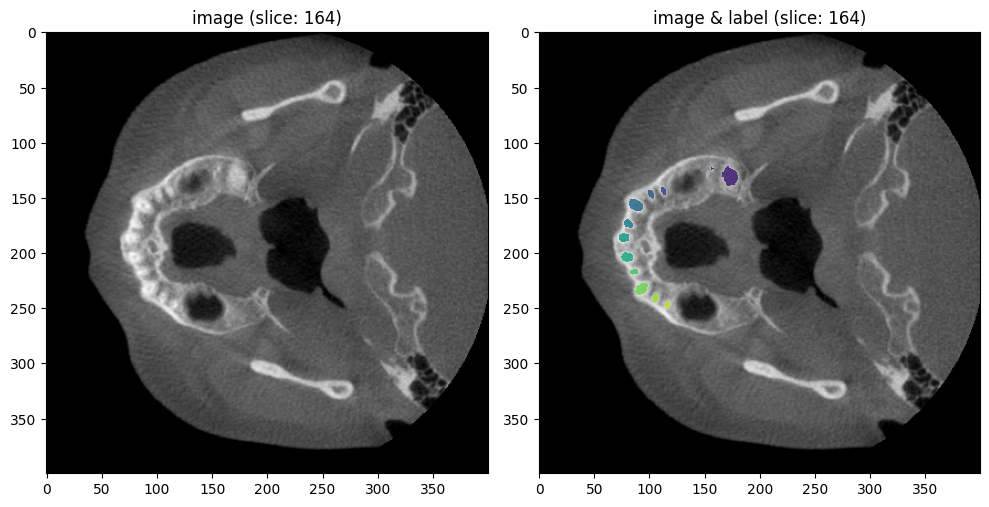

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [33]:
data_info_df = get_data_info(tr_ds)

In [34]:
data_info_df

,pid,img_shape,img_space,lbl_shape,lbl_space,lbl_ids
0,1001162439_20150708,"[400, 400, 272]","[0.4, 0.4, 0.39999962]","[400, 400, 272]","[0.4, 0.4, 0.39999962]","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
1,1001275319_20180114,"[400, 400, 280]","[0.4, 0.4, 0.40000057]","[400, 400, 280]","[0.4, 0.4, 0.40000057]","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
2,1001382496_20180423,"[400, 400, 280]","[0.4, 0.4, 0.40000057]","[400, 400, 280]","[0.4, 0.4, 0.40000057]","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
3,1001382496_20201206,"[400, 400, 328]","[0.4, 0.4, 0.39999962]","[400, 400, 328]","[0.4, 0.4, 0.39999962]","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."


In [35]:
print('avg shape')
data_shape_df = pd.DataFrame(data_info_df['img_shape'].to_list(), columns=['w', 'h', 's'])
data_shape_df.mean()

avg shape


w    400.0
h    400.0
s    290.0
dtype: float64

In [36]:
print('avg space')
data_space_df = pd.DataFrame(data_info_df['img_space'].to_list(), columns=['x', 'y', 'z'])
data_space_df.mean()

avg space


x    0.4
y    0.4
z    0.4
dtype: float32

## Statcics

In [37]:
data_dicts = tr_ds

base_tf = Compose([
    LoadImaged(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label'])
])

ds = CacheDataset(
    data=data_dicts,
    transform=base_tf
)

<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
Loading dataset: 100%|██████████| 4/4 [00:06<00:00,  1.52s/it]


In [38]:
# ref: https://arxiv.org/pdf/1904.08128.pdf
min_percentile = 0.5
max_percentile = 99.5
s = DatasetSummary(ds)
s.calculate_percentiles(min_percentile,max_percentile)
s.calculate_statistics()
data_target_space = s.get_target_spacing()

In [39]:
print('data target space:')
data_target_space

data target space:


(0.4000000059604645, 0.4000000059604645, 0.40000009536743164)

In [40]:
print('data intensities statcics:')
data_intensities_statcics = pd.DataFrame(
    [[s.data_min, s.data_median, s.data_max, s.data_mean, s.data_std, s.data_min_percentile, s.data_max_percentile]],
    columns=['min', 'med', 'max', 'mean', 'std', f'min_percentile ({min_percentile}%)', f'max_percentile ({max_percentile}%)']
)
data_intensities_statcics

data intensities statcics:


,min,med,max,mean,std,min_percentile (0.5%),max_percentile (99.5%)
0,-430.0,1319.0,5827.0,1361.655762,463.20636,218.815,3187.555


## Transform

In [41]:
space = data_target_space
a_min = s.data_min_percentile
a_max = s.data_max_percentile
teeth_transform = Compose(
      [
          LoadImaged(keys=["image", "label"]),
          AddChanneld(keys=["image", "label"]),
          Orientationd(keys=["image", "label"], axcodes="RAS"),
          Spacingd(
              keys=["image", "label"],
              pixdim=space,
              mode=("bilinear", "nearest"),
          ),
          # ScaleIntensityRangePercentilesd(
          #     keys=["image"], lower=3, upper=97, b_min=0.0, b_max=1.0, clip=True
          # ),
          ScaleIntensityRanged(
              keys=["image"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True
          ),
          ToTensord(keys=["image", "label"]),
          SqueezeDimd(keys=["image", "label"]),
      ]
  )

<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


pid: 1001162439_20150708
file_pth: /nfs/Workspace/dataset/teeth/data_29/image/1001162439_20150708.nii.gz
img shape: [400, 400, 272]
img spacing: [0.4, 0.4, 0.39999962]
lbl shape: [400, 400, 272]
lbl spacing: [0.4, 0.4, 0.39999962]
lbl ids: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]


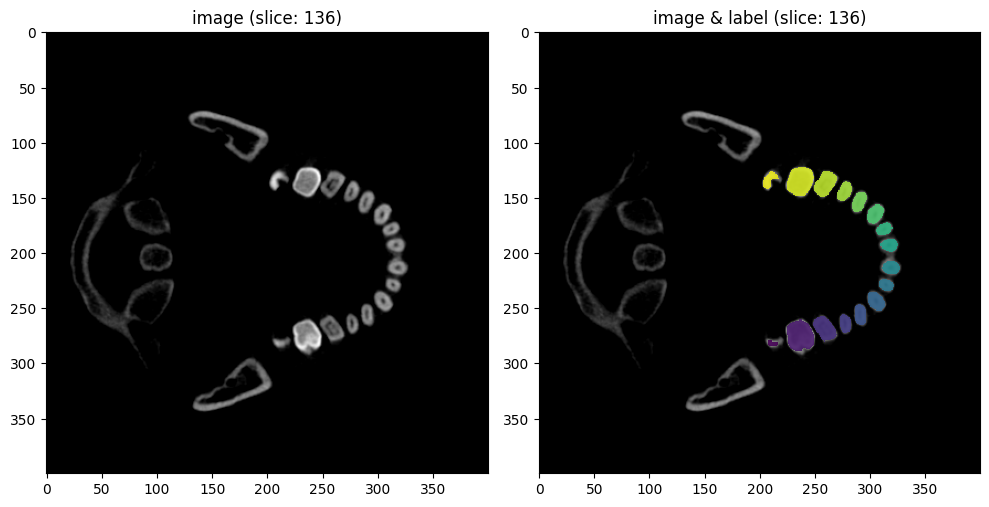

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: 1001275319_20180114
file_pth: /nfs/Workspace/dataset/teeth/data_29/image/1001275319_20180114.nii.gz
img shape: [400, 400, 280]
img spacing: [0.4, 0.4, 0.40000057]
lbl shape: [400, 400, 280]
lbl spacing: [0.4, 0.4, 0.40000057]
lbl ids: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]


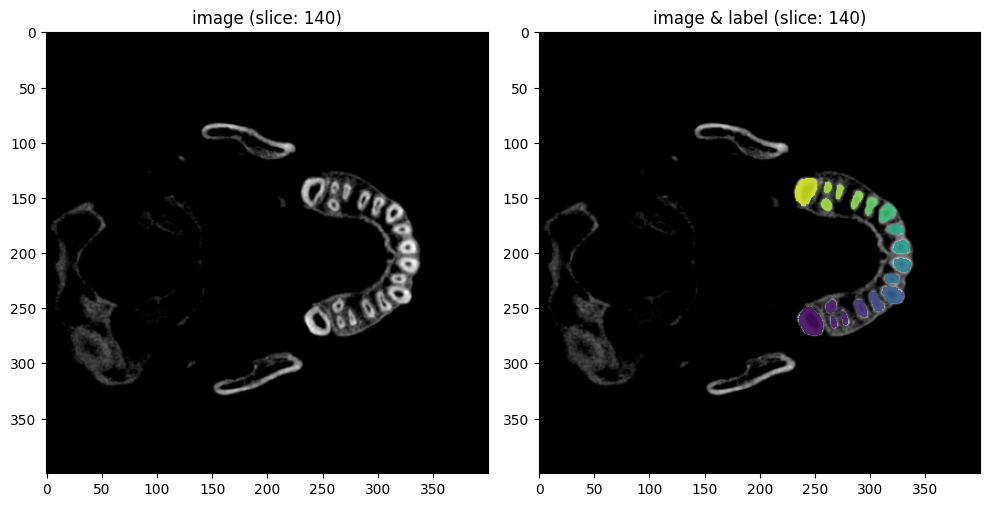

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: 1001382496_20180423
file_pth: /nfs/Workspace/dataset/teeth/data_29/image/1001382496_20180423.nii.gz
img shape: [400, 400, 280]
img spacing: [0.4, 0.4, 0.40000057]
lbl shape: [400, 400, 280]
lbl spacing: [0.4, 0.4, 0.40000057]
lbl ids: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]


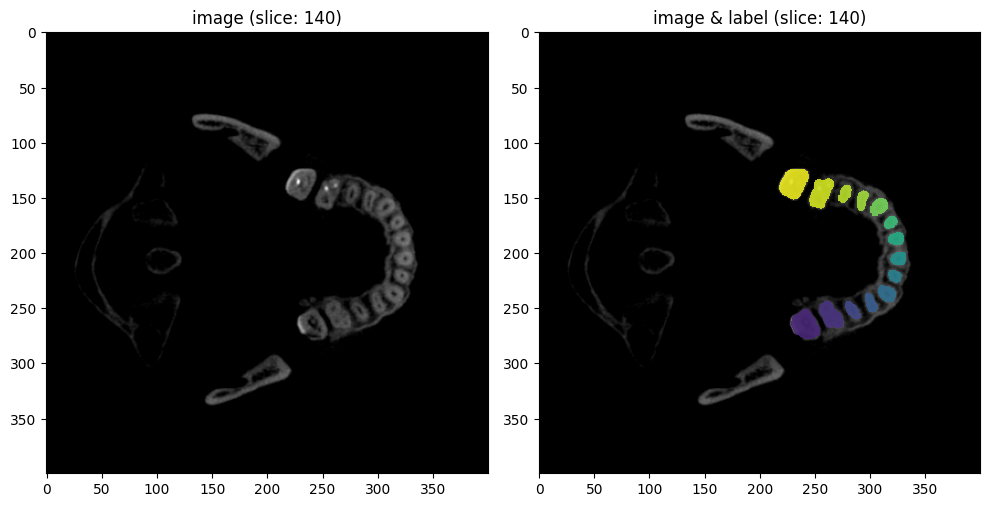

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: 1001382496_20201206
file_pth: /nfs/Workspace/dataset/teeth/data_29/image/1001382496_20201206.nii.gz
img shape: [400, 400, 328]
img spacing: [0.4, 0.4, 0.39999962]
lbl shape: [400, 400, 328]
lbl spacing: [0.4, 0.4, 0.39999962]
lbl ids: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]


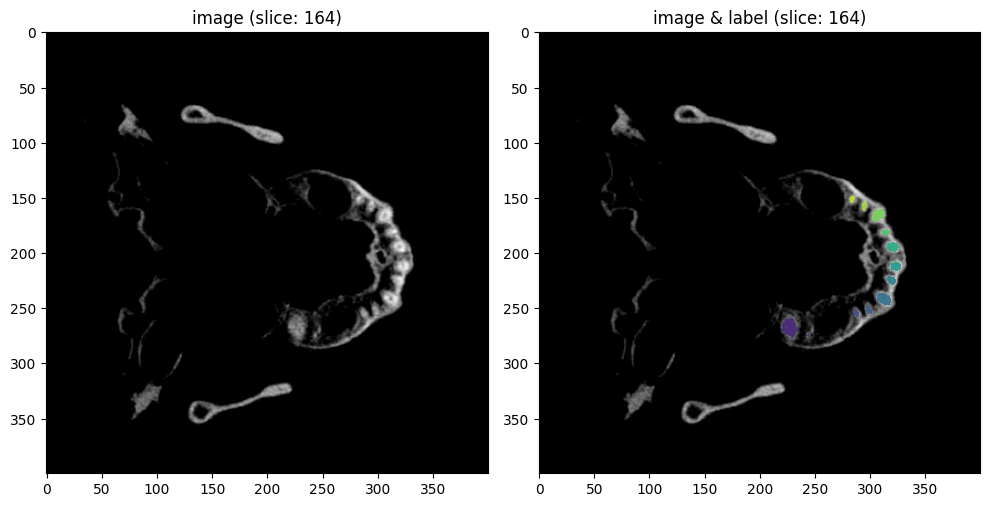

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [42]:
tf_data_info_df = get_data_info(tr_ds, teeth_transform)

In [43]:
space = data_target_space
tooth_transform = Compose(
      [
          LoadImaged(keys=["image", "label"]),
          AddChanneld(keys=["image", "label"]),
          LabelToMaskd(keys=["label"], select_labels=[i for i in range(1, 29)]),
          Orientationd(keys=["image", "label"], axcodes="RAS"),
          Spacingd(
              keys=["image", "label"],
              pixdim=space,
              mode=("bilinear", "nearest"),
          ),
          # ScaleIntensityRangePercentilesd(
          #     keys=["image"], lower=1, upper=99, b_min=0.0, b_max=1.0, clip=True
          # ),
          ScaleIntensityRanged(
              keys=["image"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True
          ),
          ToTensord(keys=["image", "label"]),
          SqueezeDimd(keys=["image", "label"]),
      ]
  )

<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


pid: 1001162439_20150708
file_pth: /nfs/Workspace/dataset/teeth/data_29/image/1001162439_20150708.nii.gz
img shape: [400, 400, 272]
img spacing: [0.4, 0.4, 0.39999962]
lbl shape: [400, 400, 272]
lbl spacing: [0.4, 0.4, 0.39999962]
lbl ids: [0. 1.]


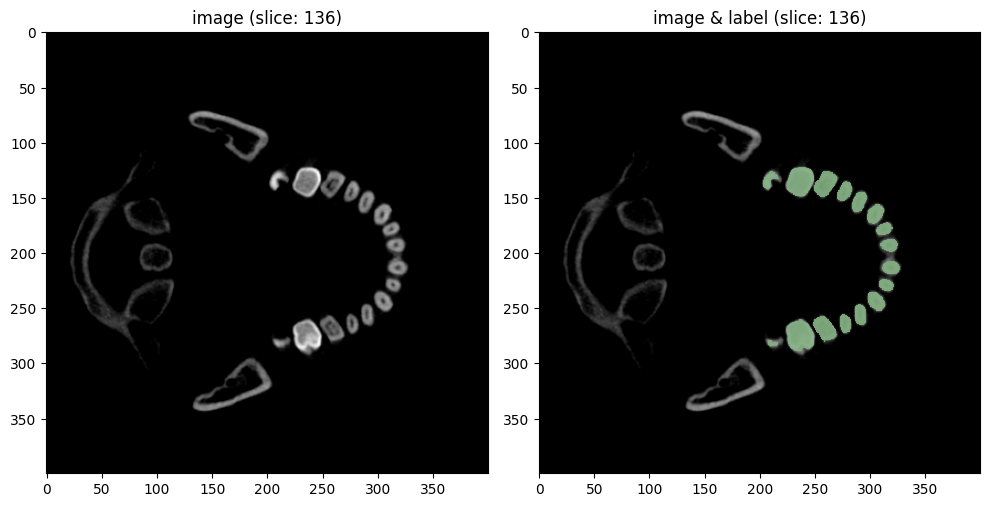

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: 1001275319_20180114
file_pth: /nfs/Workspace/dataset/teeth/data_29/image/1001275319_20180114.nii.gz
img shape: [400, 400, 280]
img spacing: [0.4, 0.4, 0.40000057]
lbl shape: [400, 400, 280]
lbl spacing: [0.4, 0.4, 0.40000057]
lbl ids: [0. 1.]


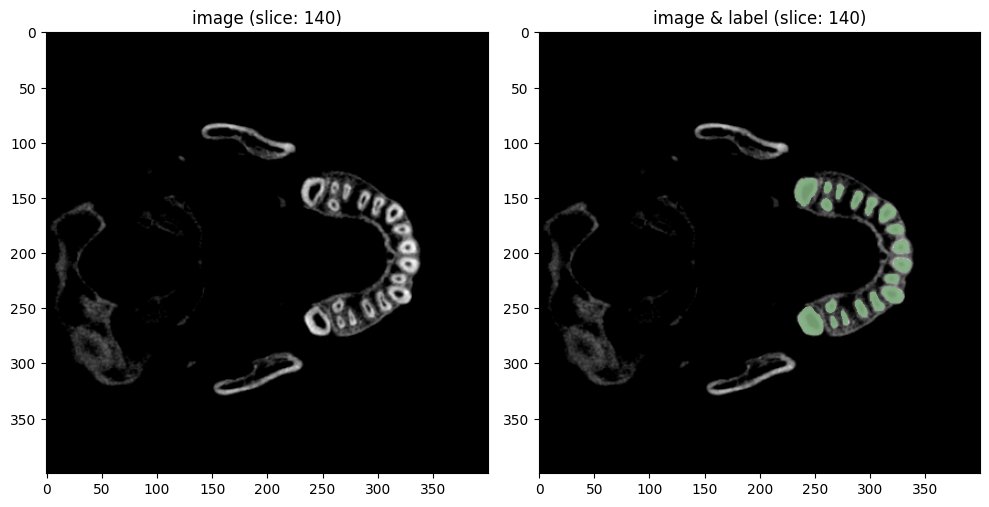

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: 1001382496_20180423
file_pth: /nfs/Workspace/dataset/teeth/data_29/image/1001382496_20180423.nii.gz
img shape: [400, 400, 280]
img spacing: [0.4, 0.4, 0.40000057]
lbl shape: [400, 400, 280]
lbl spacing: [0.4, 0.4, 0.40000057]
lbl ids: [0. 1.]


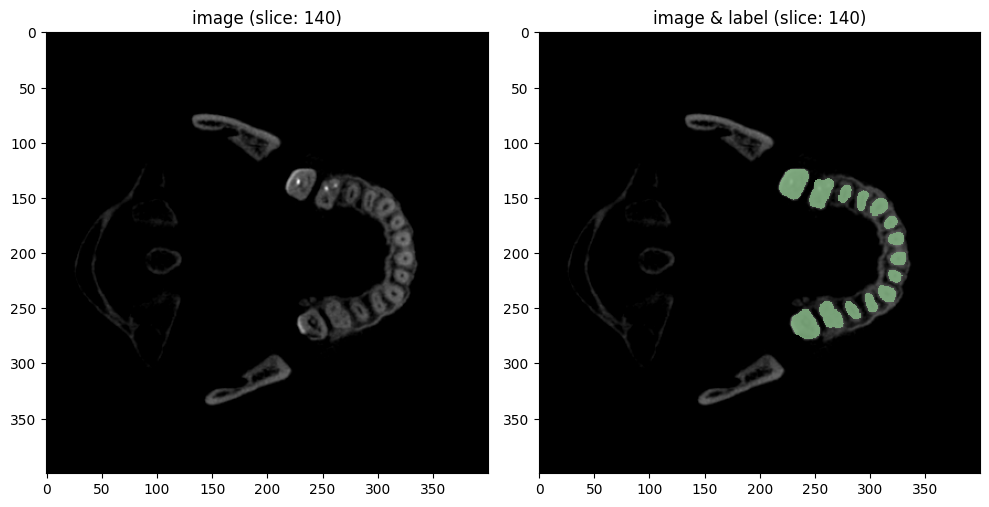

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: 1001382496_20201206
file_pth: /nfs/Workspace/dataset/teeth/data_29/image/1001382496_20201206.nii.gz
img shape: [400, 400, 328]
img spacing: [0.4, 0.4, 0.39999962]
lbl shape: [400, 400, 328]
lbl spacing: [0.4, 0.4, 0.39999962]
lbl ids: [0. 1.]


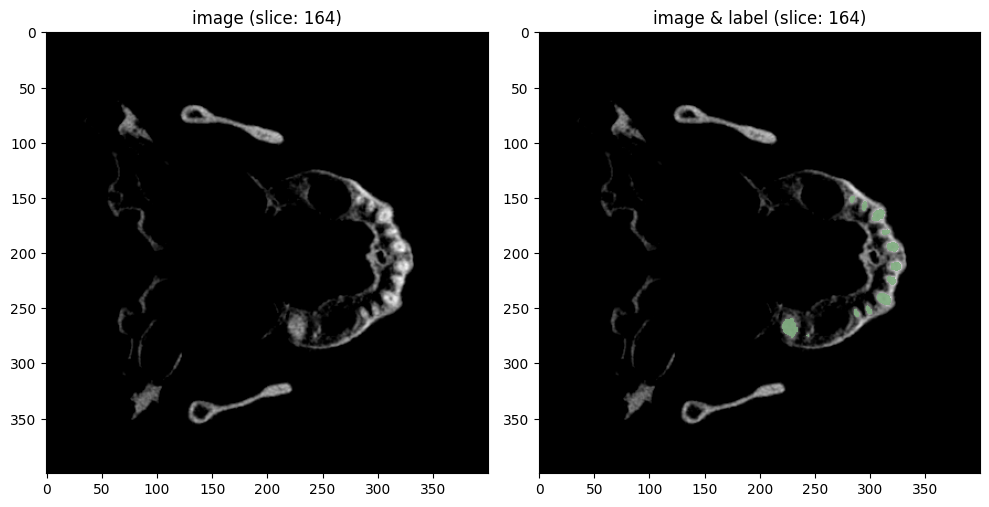

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [44]:
tf_data_info_df = get_data_info(tr_ds, tooth_transform)

## Check train/val dataloader

In [45]:
from data_utils.dataset import DataLoader
from expers.args import get_parser
from data_utils.visualization import show_img_lbl

In [46]:
data_dir = '/nfs/Workspace/dataset/teeth/data_29'
data_json = os.path.join(data_dir, 'data.json')

In [47]:
args = get_parser([])
args.data_name = 'tooth'
args.data_dir = data_dir
args.data_dicts_json = data_json
args.scale_intensity_type='range'
args.select_label_num=29
args.a_min=218
args.a_max=3187
args.roi_x=96
args.roi_y=96
args.roi_z=96
args.space_x=1.0
args.space_y=1.0
args.space_z=1.0

In [48]:
tr_ld, val_dl = DataLoader(args.data_name, args)

<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


use scale intensity by range
use scale intensity by range
load json from /nfs/Workspace/dataset/teeth/data_29/data.json
train files (4): ['1001162439_20150708', '1001275319_20180114', '1001382496_20180423', '1001382496_20201206']
val files (2): ['1001470164_20180114', '1001487462_20180109']
test files (2): ['1001487462_20180527', '1001487462_20190427']

load train dataset ...


Loading dataset: 100%|██████████| 4/4 [00:12<00:00,  3.19s/it]



load val dataset ...


Loading dataset: 100%|██████████| 2/2 [00:07<00:00,  3.55s/it]


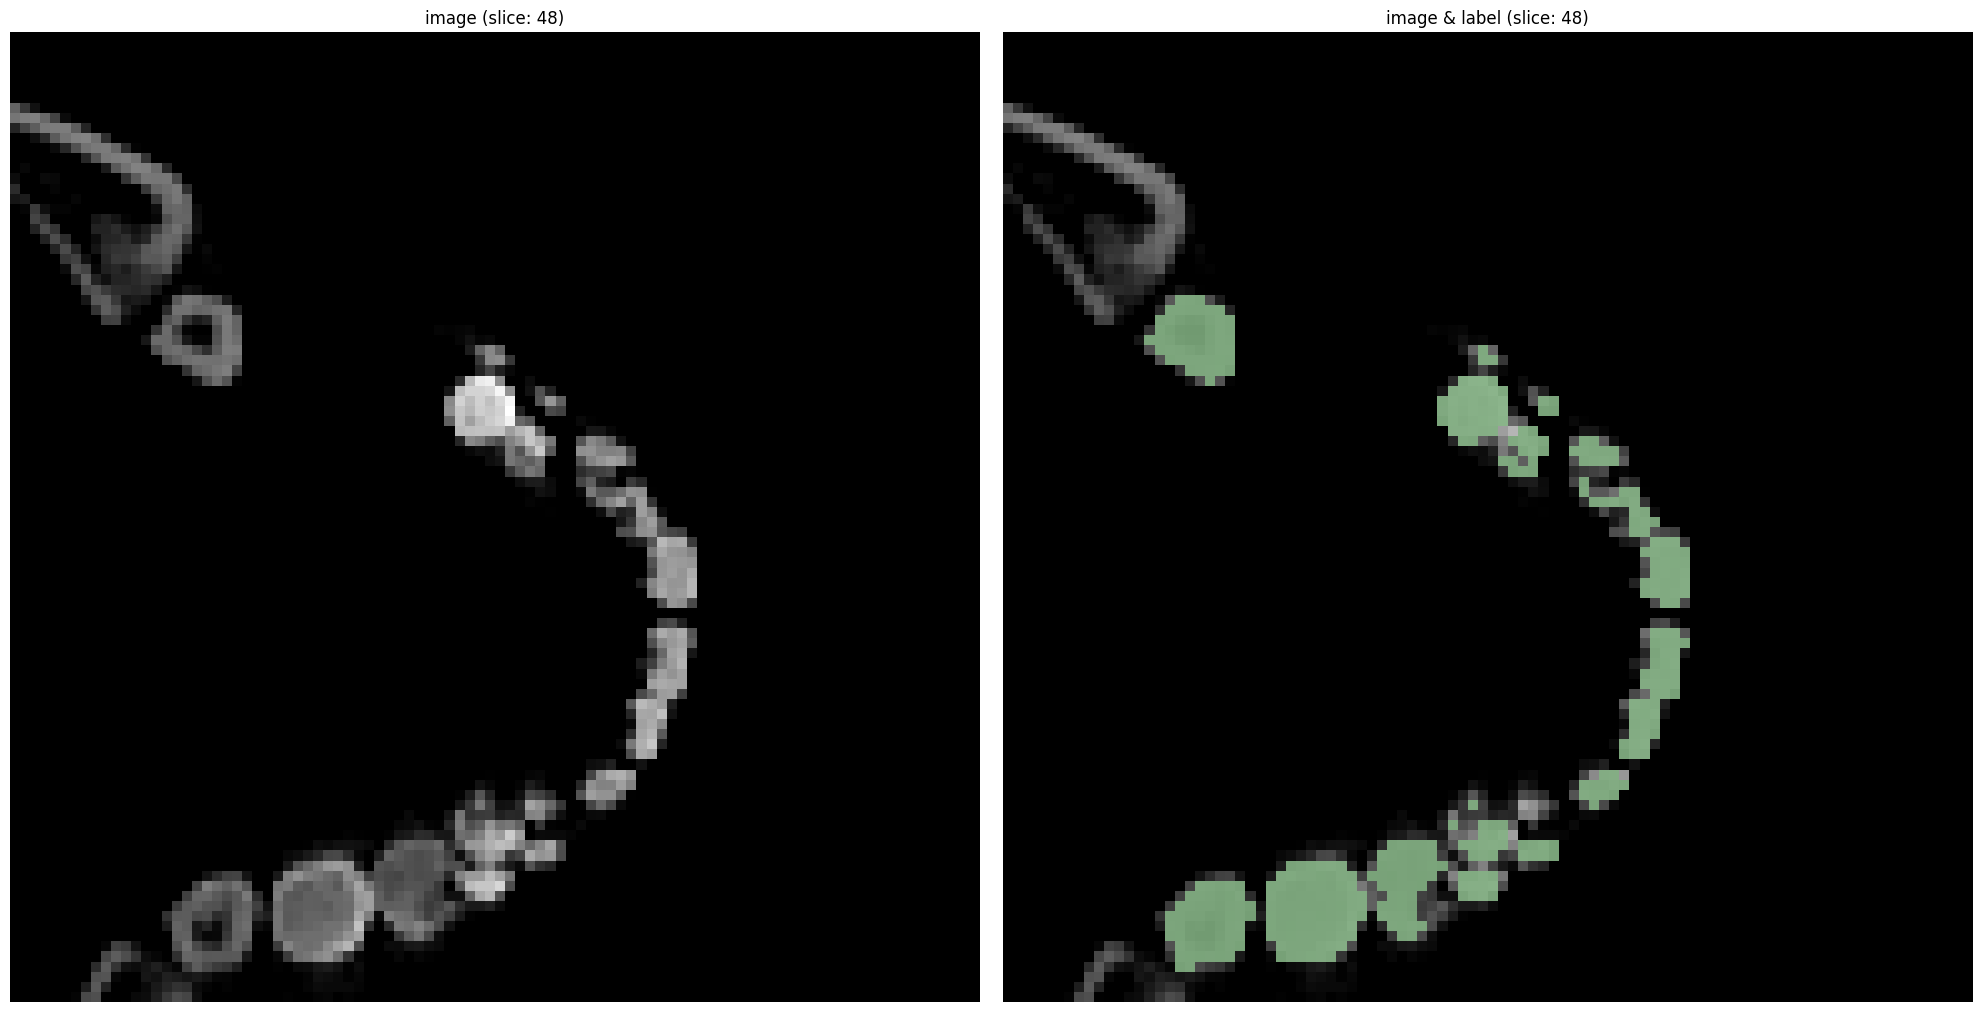

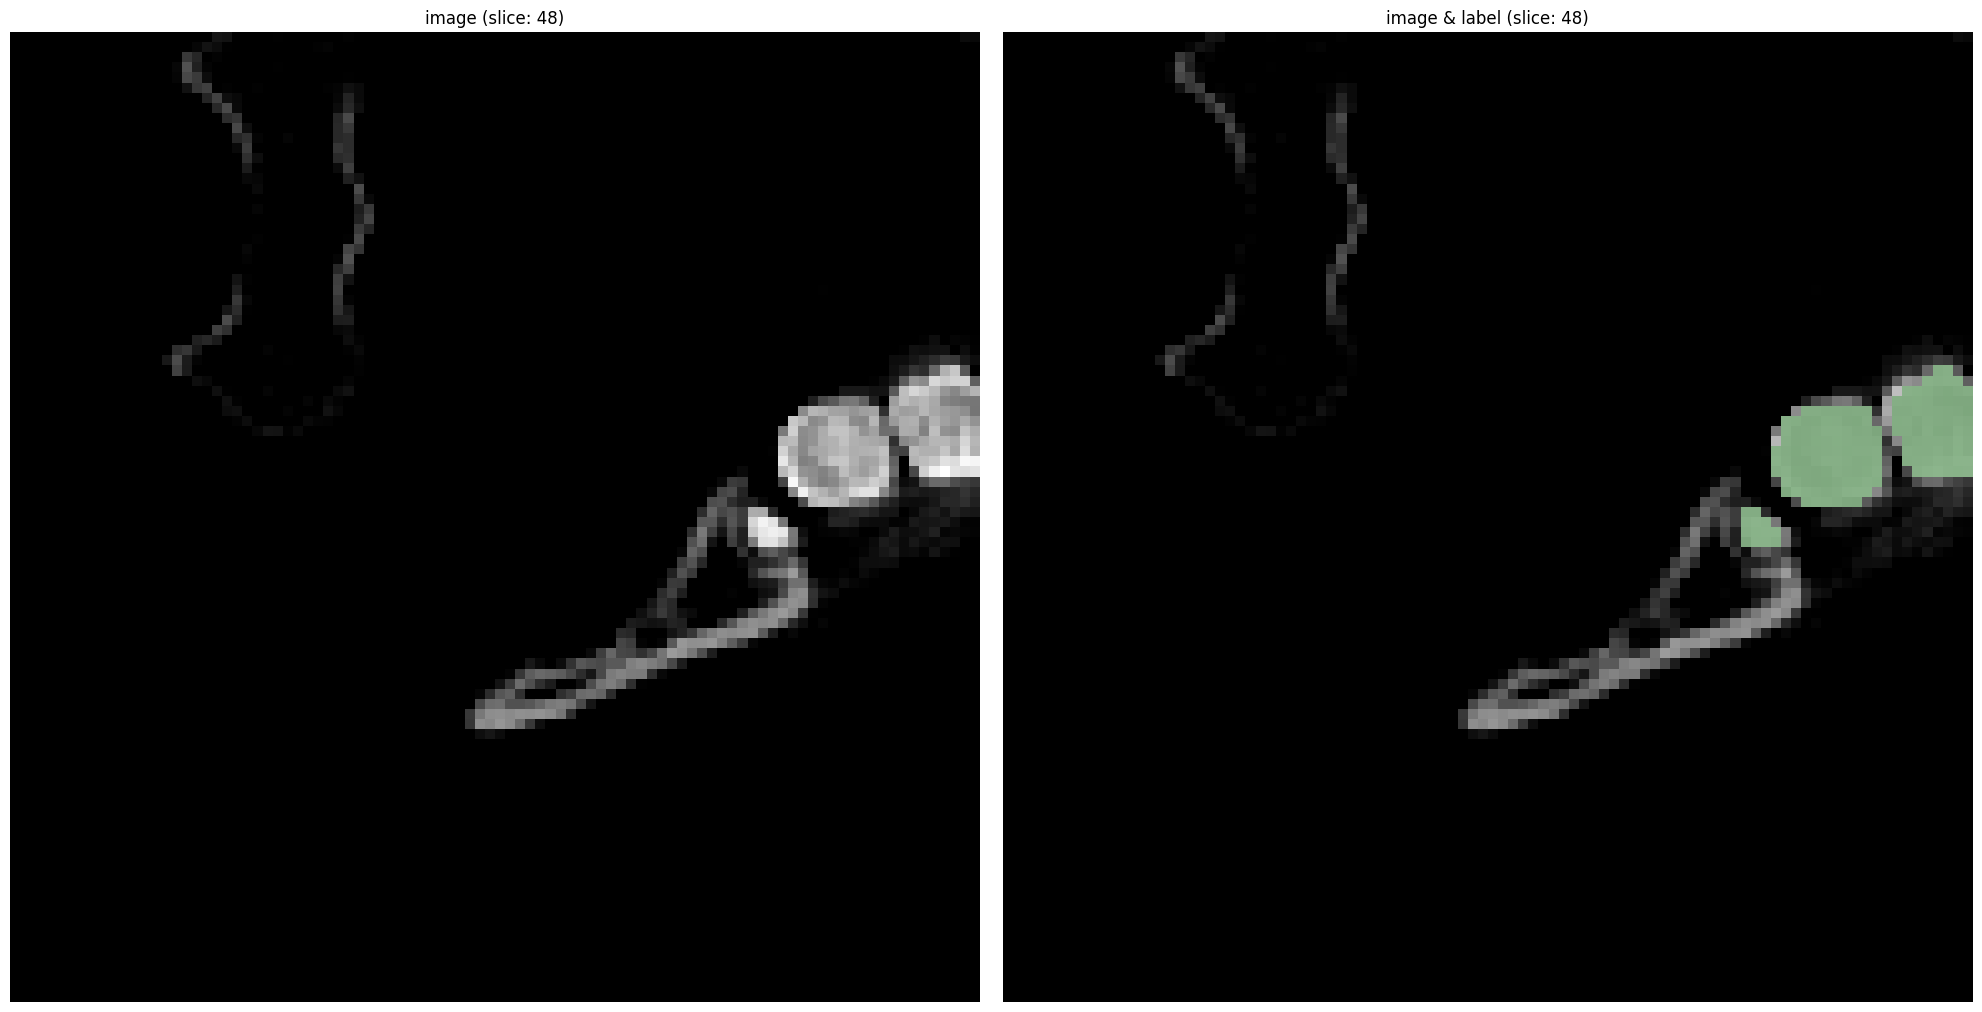

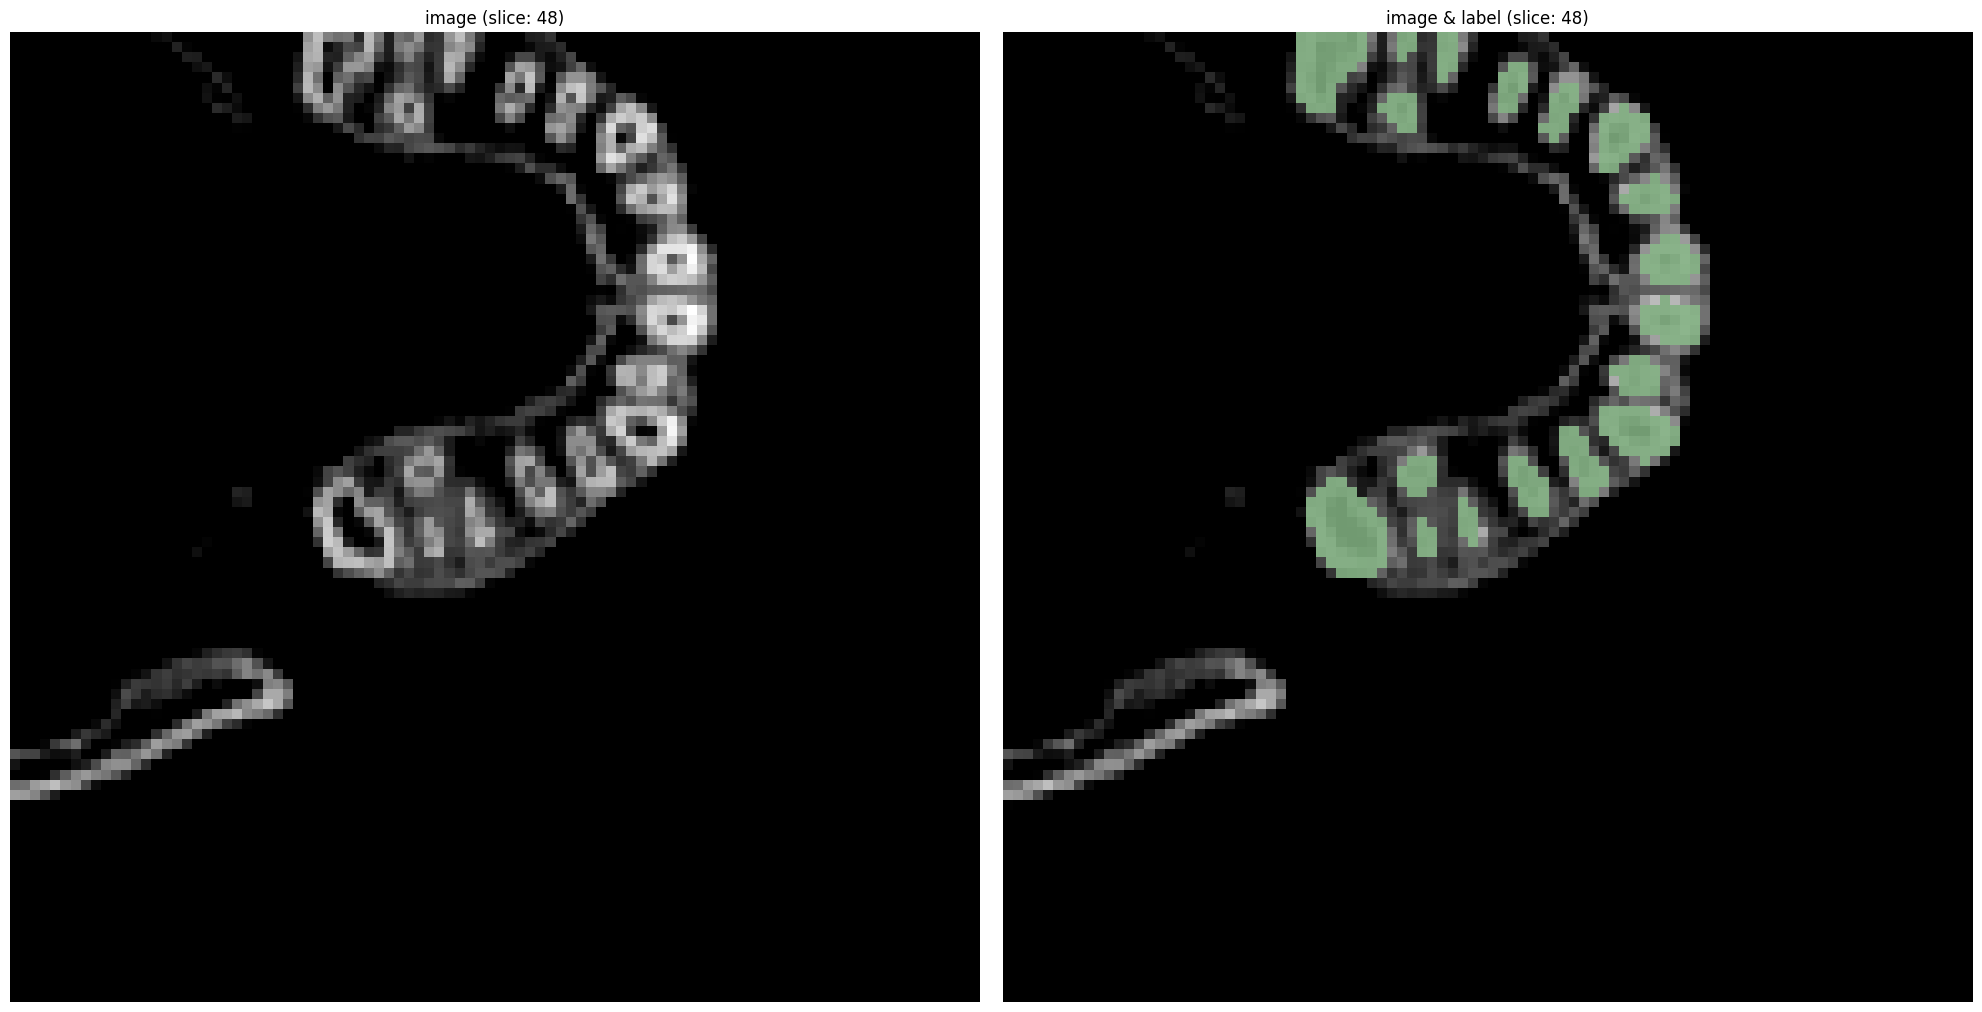

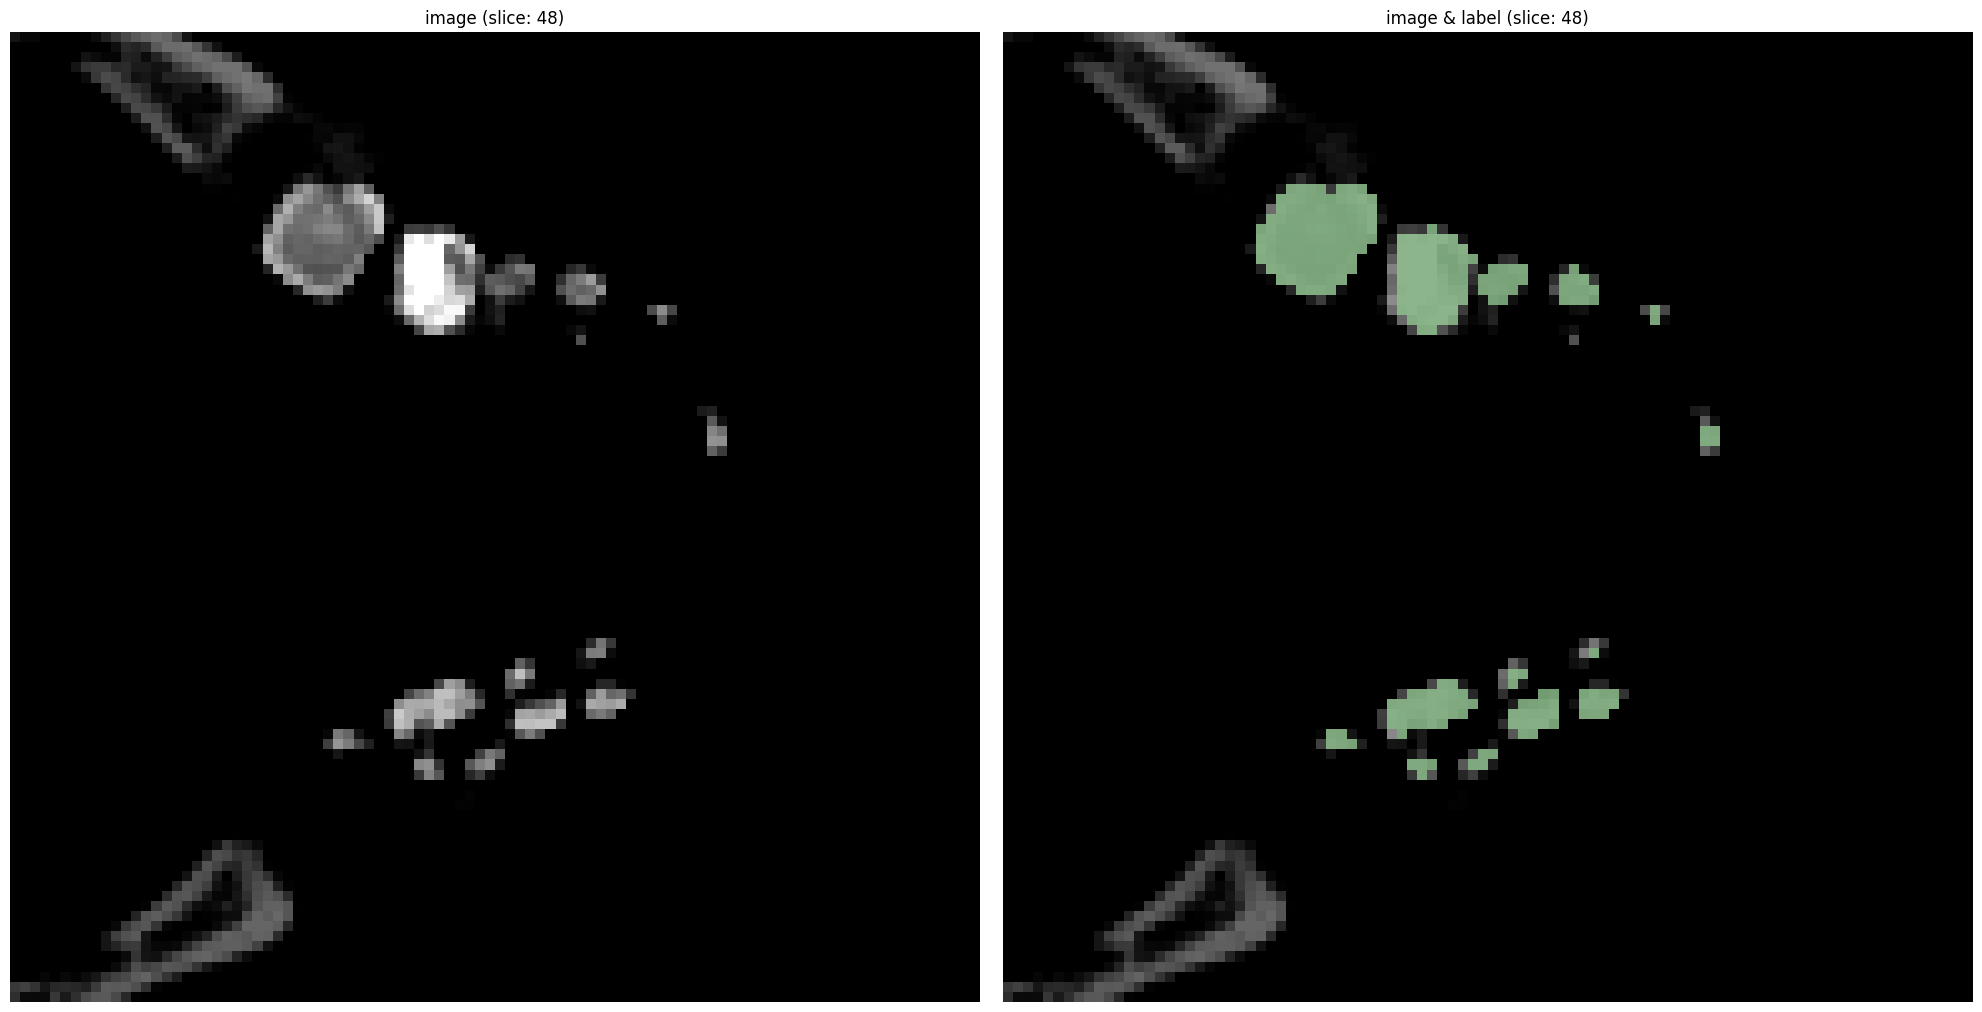

In [49]:
slice_idx = 48
num_classes = 2
for d in tr_ld:
    show_img_lbl(
        d['image'][0,0,:,:,slice_idx], 
        d['label'][0,0,:,:,slice_idx], 
        slice_idx=slice_idx,
        num_classes=num_classes
    )